# Notebook Purpose
- follow-up on QuiescentSources.ipynb and TypeDifferentiation.ipynb to better understand and separate types 5, 6, and 7; and connect these sources to transitioning sources

### Goals
- investigate ~quiescent parts of transitioning sources
- satisfactory separation of types 6 and 7
- (ideas of) how to separate 6 from other sources as well
- can re-type any 5s and 6s based on direct (LC) comparison
    - is difference extent/type of variability or timescale of variability?
- overall: want to understand boundaries between 5, 6, 7
- can add calibrated column to allsummtab.csv?

- can argue that some type 6s just haven't been given enough time (by OGLE) to be seen outside of quiescence?
    - based on timescale of transitioning sources and spin period or orbital period
### Summary

### To-Dos

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv')

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

In [2]:
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']
def plot(s):
    try: iband, vband = o.getIV(s,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [3]:
def sf(name):
    plt.savefig(f'Figs/{name}.png',dpi=150,bbox_inches='tight')

#### number and description of transitioning sources to include
- 55: transition from ~quiescence (type 6) to type 1
- 32, 30, 39, 50, 119
- parts of 10, 11, 14, 19, maybe 34, maybe 73

#### broader framing idea
- divide by faint/bright/no base using (base number and) skew
- faint base: 1 and 4 (but would probably want to re-number using this logic
    - what differentiates
        - timescale? periodicity?
        - width of flares
    - do any sources transition between 1 and 4?
    - compare/contrast color-magnitude diagrams
- bright base: 2 and 3
    - what differentiates
        - neighboring/correlated big dips
- no base: 5, 6, 7
    
    

In [4]:
tsrc = []
for a in range(len(alls)):
    row = alls.loc[a]
    sn = int(row['src_n'])
    if '+' in str(row['type']): tsrc.append(sn)

In [5]:
#transition source numbers -- ones with 6/7 part are listed in markdown above
tsrc

[2, 10, 11, 14, 19, 27, 30, 32, 34, 39, 50, 52, 73, 97, 119]

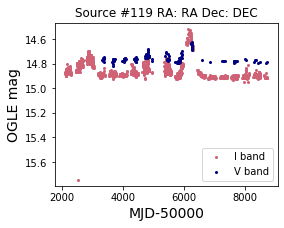

In [6]:
plot(119) #was checking which ones have quiescent parts

In [7]:
def gettype(num='6',tab=alls):
    typen = []
    for a in range(len(alls)):
        if tab.loc[a]['type']==num:
            typen.append(tab.loc[a]['src_n'])
    return typen

In [8]:
type6 = gettype()
type7 = gettype(num='7')

Text(0.5, 0, 'det I stdev/overall I stdev')

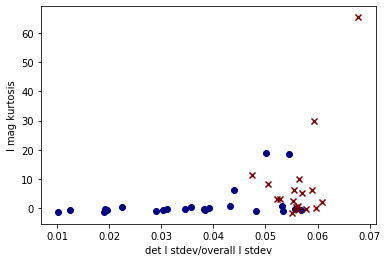

In [9]:
#IQR similar
for t in type6:
    row = alls[alls['src_n']==t]
    plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='navy')
#     plt.text(row['det stdev I']/row['I range'],row['I kurtosis'],str(int(row['src_n'])))
for t in type7:
    row = alls[alls['src_n']==t]
    plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='maroon',marker='x')
#     plt.text(row['det stdev I']/row['stdev I'],row['I kurtosis'],str(int(row['src_n'])))
plt.ylabel('I mag kurtosis')
plt.xlabel('det I stdev/overall I stdev')

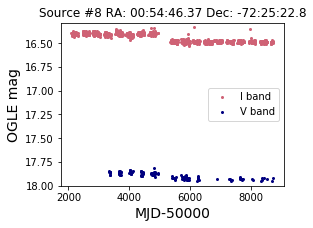

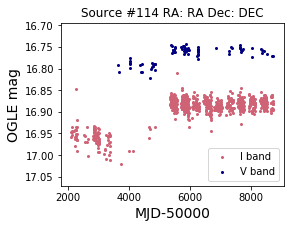

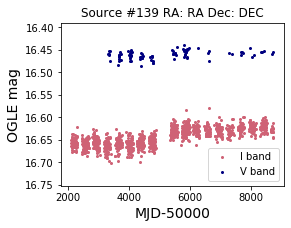

In [10]:
#maybe offset in x due to calibration so not too worried
plot(8)
plot(114)
plot(139)

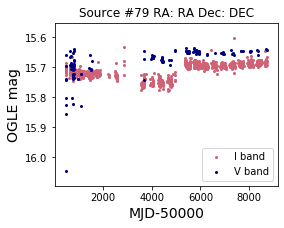

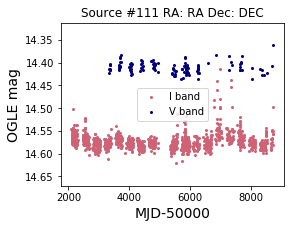

In [11]:
#potential false positives (type 6 that are in type 7 region)
plot(79) #quite possibly a type 7; need to zoom and check calibration
plot(111) #looks like type6

# Investigate Transition Sources


### get indices of approximate quiescence for each
- in dictionary idict

In [12]:
#sources to investigate in this section
nums = [55,32,30,39,50,119,10,11,14,19,34,73]

In [13]:
idict = dict.fromkeys(nums,())

In [14]:
idict

{55: (),
 32: (),
 30: (),
 39: (),
 50: (),
 119: (),
 10: (),
 11: (),
 14: (),
 19: (),
 34: (),
 73: ()}

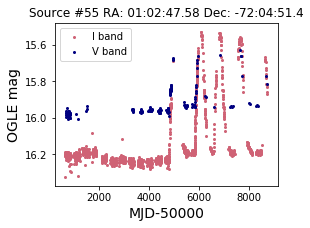

In [15]:
#first determine upper and lower inds of quiescent region for each source
n = 55
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [16]:
# plt.scatter(iband['MJD-50000'][:1000],iband['I mag'][:1000],color=pink)
idict[55] = (0,1000)

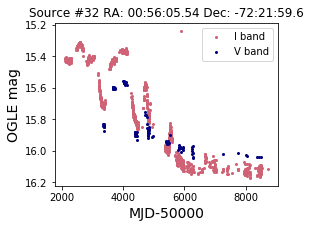

In [17]:
n = nums[1]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [18]:
# plt.scatter(iband['MJD-50000'][940:],iband['I mag'][940:],color=pink)
idict[n] = (940,1202)

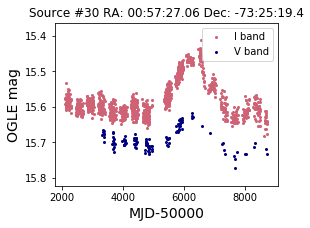

In [19]:
n = nums[2]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [20]:
# plt.scatter(iband['MJD-50000'][:730],iband['I mag'][:730],color=pink)
idict[n] = (0,730)

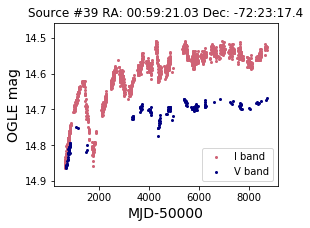

In [21]:
n = nums[3]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [22]:
#keeping edges to show retainment of periodicity
# plt.scatter(iband['MJD-50000'][1050:],iband['I mag'][1050:],color=pink)
idict[n] = (1050,1801)

<Quantity 1059.18529296>

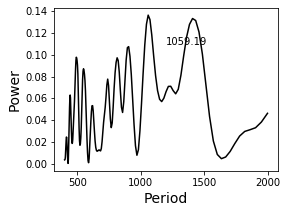

In [23]:
o.periodogram(iband,minp=400,maxp=2000)

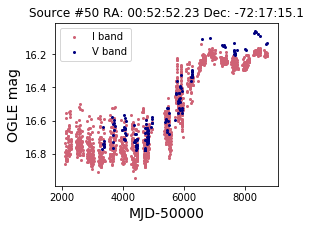

In [24]:
n = nums[4]
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [25]:
# plt.scatter(iband['MJD-50000'][:800],iband['I mag'][:800],color=pink)
idict[n] = (0,800)

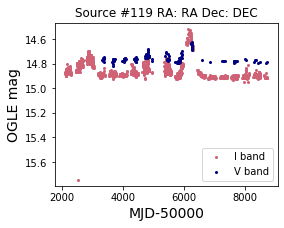

In [26]:
n = nums[5] #just use end part here
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [27]:
# plt.scatter(iband['MJD-50000'][1110:],iband['I mag'][1110:],color=pink,s=6)
idict[n] = (1110,1496)
# plt.ylim(15,14.8)

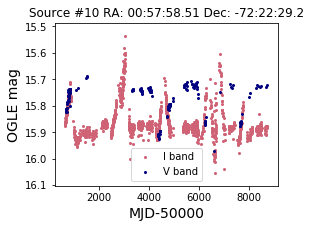

In [28]:
n = nums[6] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [29]:
#just take one good quiescent chunk
# plt.scatter(iband['MJD-50000'][610:830],iband['I mag'][610:830],color=pink,s=6)
idict[n] = (610,830)

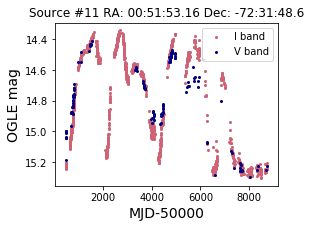

In [30]:
n = nums[7] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [31]:
# plt.scatter(iband['MJD-50000'][1340:],iband['I mag'][1340:],color=pink,s=6)
idict[n] = (1340,1495)

(5377, 9167.459000626763)

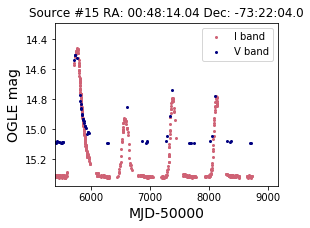

In [32]:
#sidenote: equivalent timescale to 14 for type 1 surce
plot(15)
plt.xlim(5377,)

In [33]:
np.min(iband['MJD-50000'])

466.60147

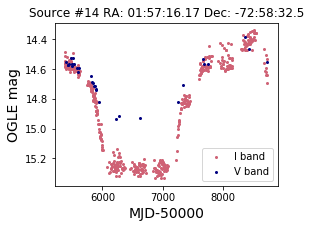

In [34]:
n = nums[8] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [35]:
# plt.scatter(iband['MJD-50000'][190:330],iband['I mag'][190:330],color=pink,s=6)
idict[n] = (190,330)

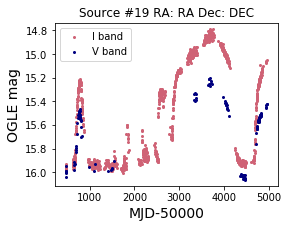

In [36]:
n = nums[9] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [37]:
# plt.scatter(iband['MJD-50000'][165:300],iband['I mag'][165:300],color=pink,s=6)
idict[n] = (165,300)

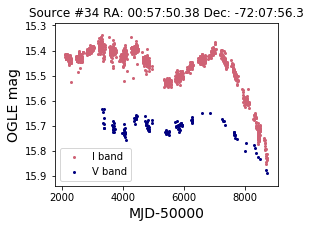

In [38]:
n = nums[10] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [39]:
#fine to use as limit between 5 and 6
# plt.scatter(iband['MJD-50000'][:600],iband['I mag'][:600],color=pink,s=6)
idict[n] = (0,600)

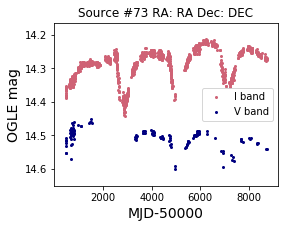

In [40]:
n = nums[11] 
try: iband, vband = o.getIV(n,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(n,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [41]:
# plt.scatter(iband['MJD-50000'][170:500],iband['I mag'][170:500],color=pink,s=6)
idict[n] = (170,500) #quite approximate; repeated throughout lightcurve

In [42]:
idict #now have indices of ~quiescence for weird/transitioning sources
#other sources sometimes have ~quiescence for this long

{55: (0, 1000),
 32: (940, 1202),
 30: (0, 730),
 39: (1050, 1801),
 50: (0, 800),
 119: (1110, 1496),
 10: (610, 830),
 11: (1340, 1495),
 14: (190, 330),
 19: (165, 300),
 34: (0, 600),
 73: (170, 500)}

### periodicity search within quiescence
- be careful since not a lot of points for some
- show periodograms and phase-folded data

In [43]:
len(nums)

12

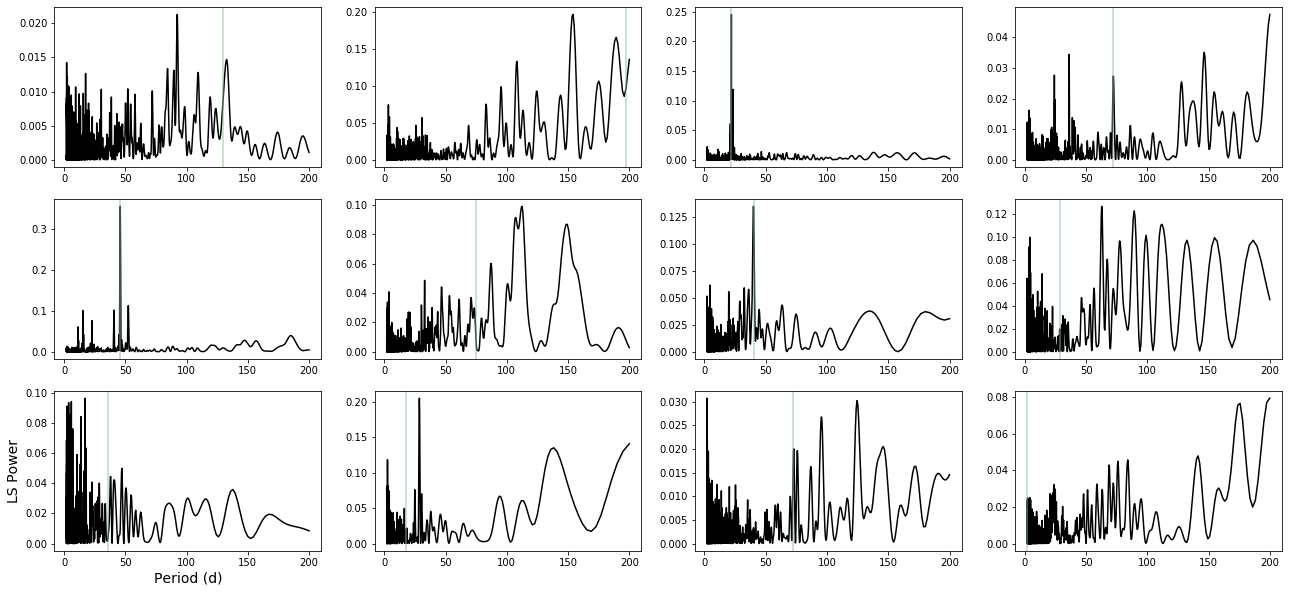

In [44]:
#loop through sources and look at power in LS periodogram
#remake into subplots to not have such long output
fig = plt.figure(figsize=(22,10))
i = 1
for n in nums:
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    #run periodogram using inds from idict
    start,end = idict[n][0],idict[n][1]
    ax = fig.add_subplot(3,4,i)
    freq,power,bp = o.periodogram(iband[start:end],minp=2,maxp=200,more=True,plot=False)
    ax.plot(1/freq,power,color='black')
    row = alls[alls['src_n']==n]
    if float(row['est. period'])!=0: 
        bp = float(row['est. period'])
#         print(pd)
        ax.axvline(bp,color='darkseagreen',alpha=0.6)
    else: 
        bp = float(row['best auto det pd'])
#         print(pd)
        ax.axvline(bp,color='darkseagreen',alpha=0.6) 
    if i == 9:
        ax.set_ylabel('LS Power',fontsize=14)
        ax.set_xlabel('Period (d)',fontsize=14)
        
    i+=1
    
# sf('transition_pd')

summary: general retainment of (some) periodicity, often the best/established period
- low sampling sometimes, so wouldn't draw conclusion that period changed
- follow-up below: **phase-folding each**

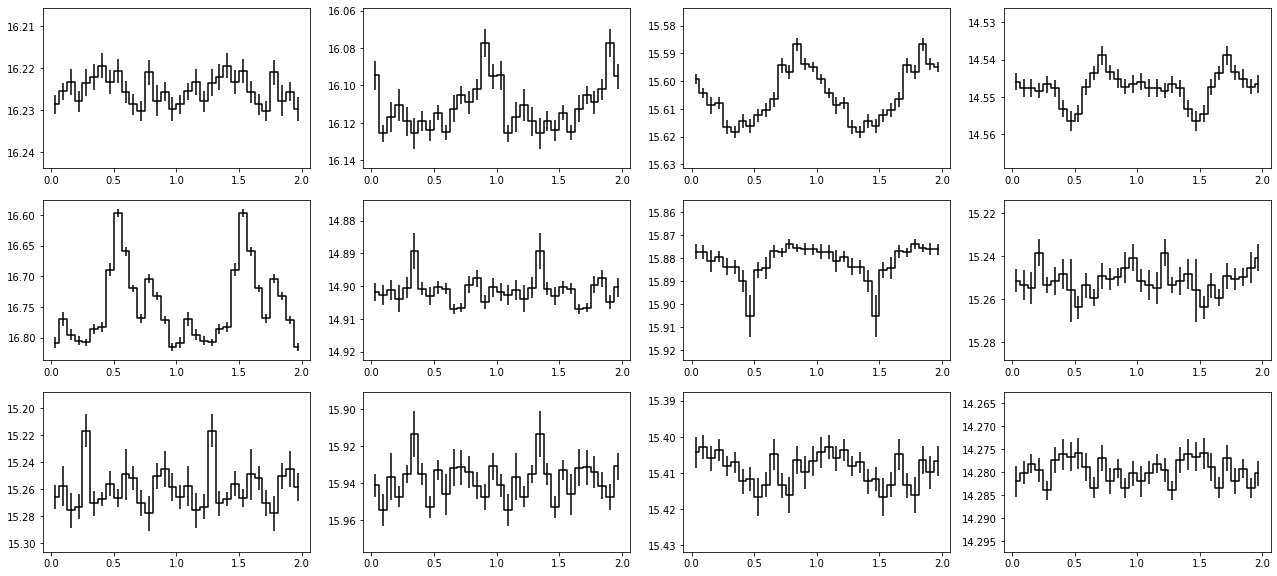

In [45]:
fig = plt.figure(figsize=(22,10))
i = 1
for n in nums:
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    start,end = idict[n][0],idict[n][1]
    ax = fig.add_subplot(3,4,i)
    #get best overall detrended period from table
    row = alls[alls['src_n']==n]
    bp = float(row['best auto det pd'])
    #plot phase-fold with subset of points
    mid,avg,err = o.meanphase(iband[start:end],bp,pbins=16,det=False,med=False,double=True,stdev=True,divide=True,sterr=True)
    ax.step(mid,avg,where='mid',color='black')
    ax.errorbar(mid,avg,yerr=err,color='black',linestyle='none')
    maxi,mini = np.max(avg)+np.max(err),np.min(avg)-np.max(err)
    ax.set_ylim(maxi+.01,mini-.01)
    i+=1
# sf('transition_pf')

above: no detrending, but shouldn't be important
- take-away: not seeing a disappearance in period
- a couple don't look fantastic but generally good --> already seems more type 6 than 7

### plot on kurtosis vs. ___ plot


In [46]:
tkurt = []
tskew = []
tstd = []
tdetstd = []
#get kurtosis, skew, stdev
for n in nums: 
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    #indices from dict
    start,end = idict[n][0],idict[n][1]
    tkurt.append(st.kurtosis(iband['I mag'][start:end]))
    tskew.append(st.skew(iband['I mag'][start:end]))
    stdev = np.std(iband['I mag'][start:end])
    tstd.append(stdev)
    #detrend to get detrended std
    ctab = iband[start:end]
    o.splinedetrend(ctab,window=20)
    tdetstd.append(np.std(ctab['I detrend'])/stdev)

Text(0, 0.5, 'I kurtosis')

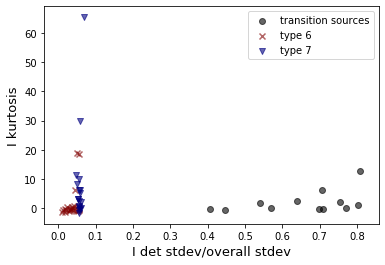

In [49]:
#see that spline detrending not so good here b/c of timescale
t6kurt = []
t7kurt = []
plt.scatter(tdetstd,tkurt,color='black',label='transition sources',alpha=0.6)
for t in type6:
    row = alls[alls['src_n']==t]
    if t==type6[0]:  plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='maroon',marker='x',alpha=0.6,label='type 6')
    else: plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='maroon',marker='x',alpha=0.6)
    t6kurt.append(float(row['I kurtosis']))
for t in type7:
    row = alls[alls['src_n']==t]
    if t==type7[0]:  plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='navy',marker='v',alpha=0.6,label='type 7')
    else:plt.scatter(row['det stdev I']/row['stdev I'],row['I kurtosis'],color='navy',marker='v',alpha=0.6)
    t7kurt.append(float(row['I kurtosis']))
# plt.xlim(0,.1)
plt.legend()
# plt.ylim(-2,10)
plt.xlabel('I det stdev/overall stdev',fontsize=13)
plt.ylabel('I kurtosis',fontsize=13)

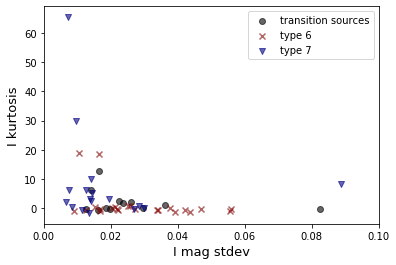

In [50]:
t6kurt = []
t7kurt = []
plt.scatter(tstd,tkurt,color='black',label='transition sources',alpha=0.6)
for t in type6:
    row = alls[alls['src_n']==t]
    if t==type6[0]:  plt.scatter(row['stdev I'],row['I kurtosis'],color='maroon',marker='x',alpha=0.6,label='type 6')
    else: plt.scatter(row['stdev I'],row['I kurtosis'],color='maroon',marker='x',alpha=0.6)
    t6kurt.append(float(row['I kurtosis']))
for t in type7:
    row = alls[alls['src_n']==t]
    if t==type7[0]:  plt.scatter(row['stdev I'],row['I kurtosis'],color='navy',marker='v',alpha=0.6,label='type 7')
    else:plt.scatter(row['stdev I'],row['I kurtosis'],color='navy',marker='v',alpha=0.6)
    t7kurt.append(float(row['I kurtosis']))
plt.xlim(0,.1)
plt.legend()
# plt.ylim(-2,10)
plt.xlabel('I mag stdev',fontsize=13)
plt.ylabel('I kurtosis',fontsize=13)
sf('67transition_stdkurt')

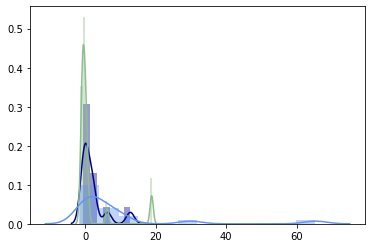

In [47]:
sb.distplot(tkurt,color='navy')
sb.distplot(t6kurt,color='darkseagreen')
sb.distplot(t7kurt,color='cornflowerblue')
#transition looking like combo of 6 and 7, also as shown in scatter plot

### by-eye characterization using plot subsets

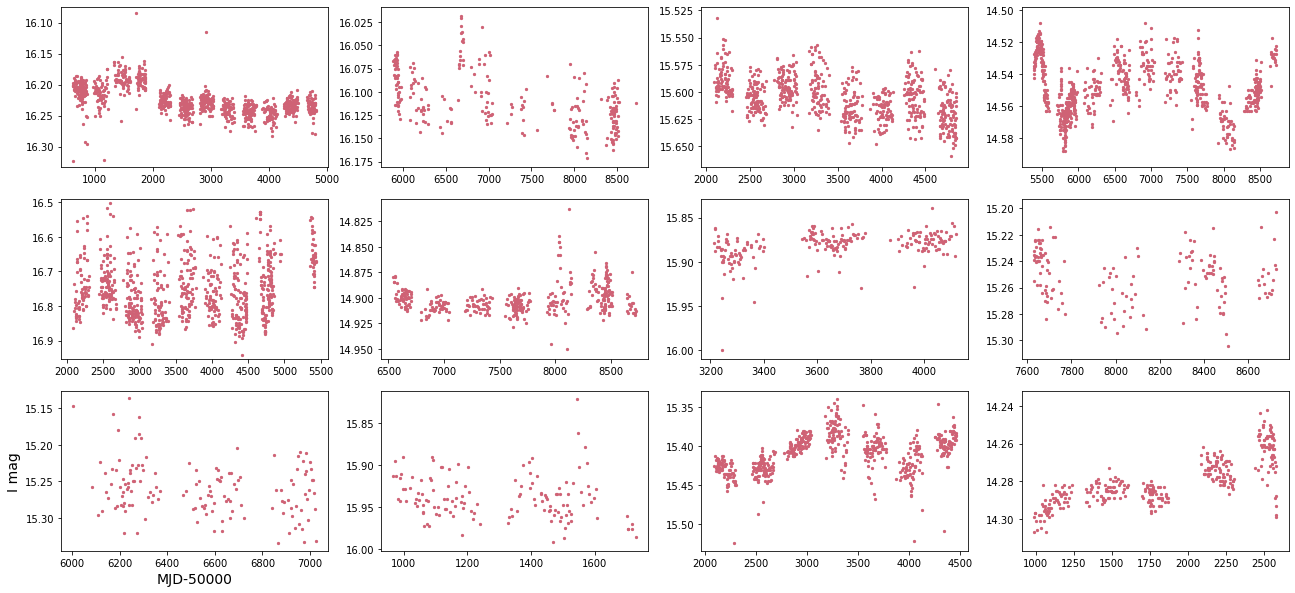

In [48]:
fig = plt.figure(figsize=(22,10))
i = 1
for n in nums:
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    start,end = idict[n][0],idict[n][1]
    ax = fig.add_subplot(3,4,i)
    tab = iband[start:end]
    ax.scatter(tab['MJD-50000'],tab['I mag'],color=pink,s=5)
    maxi,mini = np.max(tab['I mag']),np.min(tab['I mag'])
    ax.set_ylim(maxi+.01,mini-.01)
    if i == 9:
        ax.set_ylabel('I mag',fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=14)    
    i+=1

### look at timescales for transitioning sources
- length of quiescence
- spin period
- orbital period

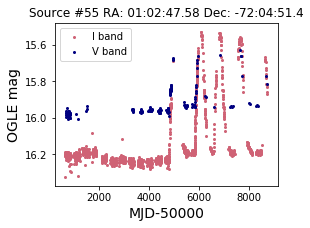

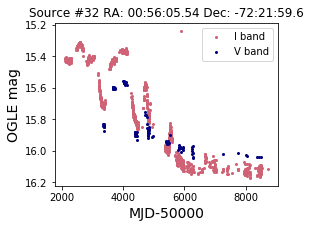

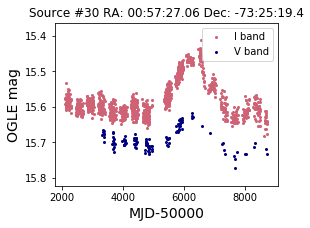

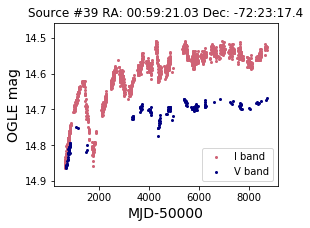

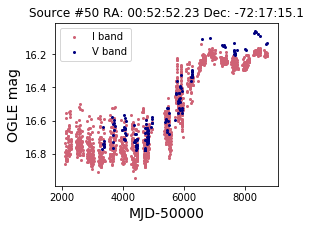

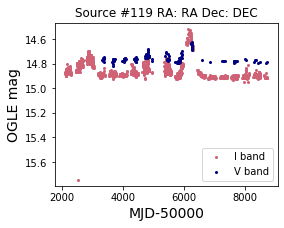

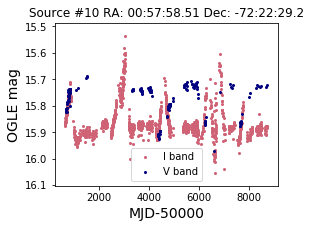

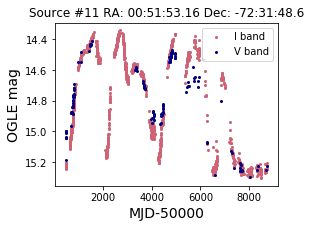

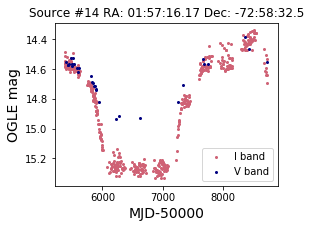

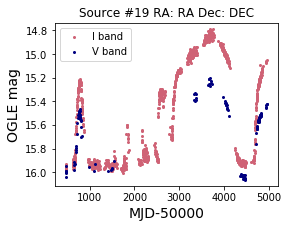

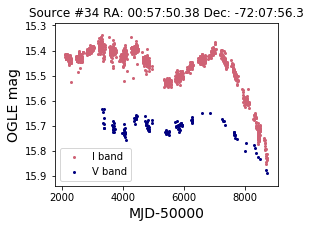

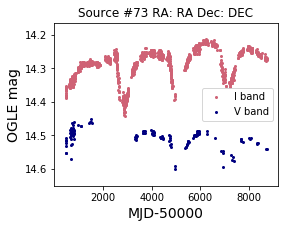

In [49]:
for n in nums:
    plot(n)

In [50]:
#manually going through and putting flag at 1 if quiescence continues into past or future (on boundaries)
minflag = [1,1,1,0,1,1,0,1,0,0,0,0]

In [51]:
#get duration of quiescence, orbital period, and spin period (and add to list)
qdur = []
orb = []
spins = []
#also compare overall detrended stdev to stdev during quiescence
sfrac = []
for n in nums:
    #get LC
    try: iband, vband = o.getIV(n,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(n,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    start,end = idict[n][0],idict[n][1]
    o.splinedetrend(iband)
    sf = np.std(iband['I mag'][start:end])/np.std(iband['I detrend'])
    sfrac.append(sf)
    #get duration
    d = iband['MJD-50000'][end-1:end] - iband['MJD-50000'][start:start+1]
    qdur.append(float(d))
    #row of table for orbital and spin periods
    row = alls[alls['src_n']==n]
    orb.append(float(row['best auto det pd']))
    s = float(row['spin period'])
    if s==0: spins.append(np.nan)
    else: spins.append(s)

In [52]:
#get quiescent durations for types 6 and 7
t6dur = []
t7dur = []
for t in type6:
    try: iband, vband = o.getIV(t,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(t,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    d = iband['MJD-50000'][-1:] - iband['MJD-50000'][:1]
    t6dur.append(float(d))
#repeating for type 7
for t in type7:
    try: iband, vband = o.getIV(t,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(t,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    d = iband['MJD-50000'][-1:] - iband['MJD-50000'][:1]
    t7dur.append(float(d))

empty file for OIII I
empty file for OII I


In [53]:
#make tables for type 6 and type 7 to stop having to loop through every time
# import pandas as pd
tab6 = alls[alls['src_n']==type6[0]]
for t in type6[1:]:
    temp = alls[alls['src_n']==t]
    tab6 = pd.concat([tab6,temp])
tab7 = alls[alls['src_n']==type7[0]]
for t in type7[1:]:
    temp = alls[alls['src_n']==t]
    tab7 = pd.concat([tab7,temp])

In [54]:
#change spin periods of 0 to nan
rows = tab6[tab6['spin period']==0]
rows['spin period'] = np.nan
tab6[tab6['spin period']==0] = rows
rows = tab7[tab7['spin period']==0]
rows['spin period'] = np.nan
tab7[tab7['spin period']==0] = rows

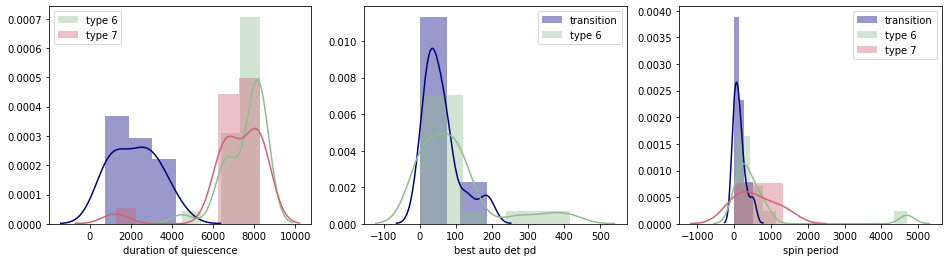

In [55]:
#compare each timescale to those of type 6 and 7
fig,ax = plt.subplots(1,3,figsize=(16,4))
sb.distplot(qdur,ax=ax[0],color='navy')
sb.distplot(t6dur,ax=ax[0],color='darkseagreen',label='type 6')
sb.distplot(t7dur,ax=ax[0],color=pink,label='type 7')
ax[0].legend()

ax[0].set_xlabel('duration of quiescence')
sb.distplot(orb,ax=ax[1],label='transition',color='navy')
sb.distplot(tab6['best auto det pd'],ax=ax[1],label='type 6',color='darkseagreen')
ax[1].legend()
# sb.distplot(tab7['best auto det pd'],ax=ax[1],label='type 7')

sb.distplot(spins,ax=ax[2],label='transition',color='navy')
sb.distplot(tab6['spin period'],ax=ax[2],label='type 6',color='darkseagreen')
sb.distplot(tab7['spin period'],ax=ax[2],label='type 7',color=pink)

ax[2].legend()

In [56]:
#type 7 that are NOT aperiodic (so can be used below)
tab7['q dur'] = t7dur
tper7 = tab7[tab7['aperiodic']!='YES']

(-100, 1500)

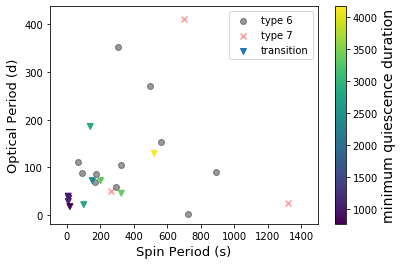

In [57]:
#scatter spin period and orbital period
plt.scatter(tab6['spin period'],tab6['best auto det pd'],color='black',alpha=0.4,label='type 6') #outlier is SNR
plt.scatter(tper7['spin period'],tper7['best auto det pd'],marker='x',color='red',alpha=0.4,label='type 7') 
plt.scatter(spins,orb,marker='v',c=qdur,label='transition') 
cb = plt.colorbar()
cb.set_label(label='minimum quiescence duration',fontsize=14)
# for n in range(len(nums)):
#     if nums[n] == 32 or nums[n] == 55:
#         plt.text(spins[n],orb[n],str(nums[n]))
plt.legend()
plt.xlabel('Spin Period (s)',fontsize=13)
plt.ylabel('Optical Period (d)',fontsize=13)

#cutting out outlier
plt.xlim(-100,1500)
# plt.savefig('Figs/qtimescale_comparison.png',dpi=200,bbox_inches='tight')

(-100, 1500)

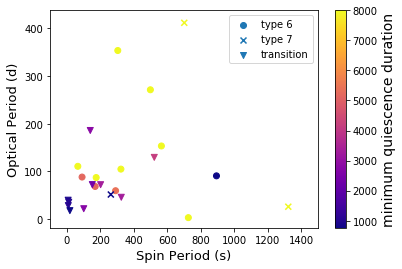

In [58]:
#version with all quiescence durations shown
plt.scatter(tab6['spin period'],tab6['best auto det pd'],c=t6dur,label='type 6',vmax=8000,cmap='plasma') #outlier is SNR
plt.scatter(tper7['spin period'],tper7['best auto det pd'],marker='x',c=tper7['q dur'],label='type 7',vmax=8000,cmap='plasma') 
plt.scatter(spins,orb,marker='v',c=qdur,label='transition',vmax=8000,cmap='plasma') 
cb = plt.colorbar()
cb.set_label(label='minimum quiescence duration',fontsize=14)
# for n in range(len(nums)):
#     if nums[n] == 32 or nums[n] == 55:
#         plt.text(spins[n],orb[n],str(nums[n]))
plt.legend()
plt.xlabel('Spin Period (s)',fontsize=13)
plt.ylabel('Optical Period (d)',fontsize=13)

#cutting out outlier
plt.xlim(-100,1500)

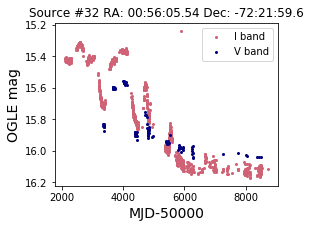

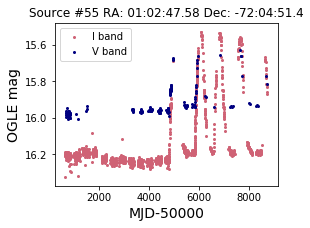

In [59]:
plot(32)
plot(55)

Text(0, 0.5, 'Spin Period (s)')

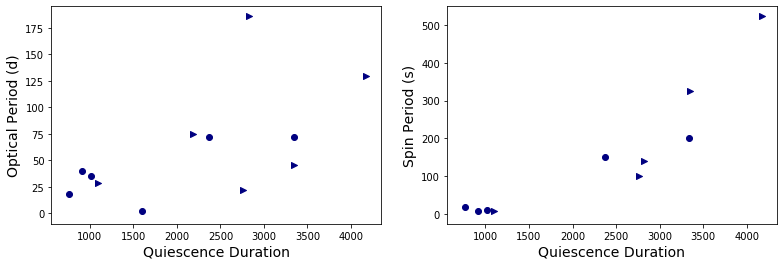

In [60]:
fig,ax = plt.subplots(1,2,figsize=(13,4))
#do in loop here to use min flag
for n in range(len(nums)):
    if minflag[n]==0:marker='o'
    else: marker='>'
    ax[0].scatter(qdur[n],orb[n],color='navy',marker=marker)
    ax[1].scatter(qdur[n],spins[n],color='navy',marker=marker)


ax[1].set_xlabel('Quiescence Duration',fontsize=14)
ax[0].set_xlabel('Quiescence Duration',fontsize=14)
ax[0].set_ylabel('Optical Period (d)',fontsize=14)
ax[1].set_ylabel('Spin Period (s)',fontsize=14)
# plt.savefig('Figs/transition_timescale.png',dpi=200,bbox_inches='tight')

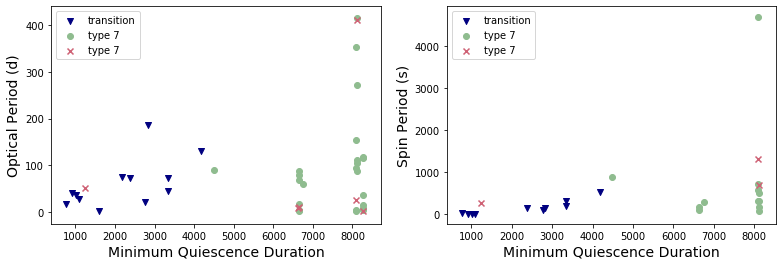

In [61]:
fig,ax = plt.subplots(1,2,figsize=(13,4))
ax[0].scatter(qdur,orb,color='navy',marker='v',label='transition')
ax[1].scatter(qdur,spins,color='navy',marker='v',label='transition')
ax[0].scatter(t6dur,tab6['best auto det pd'],color='darkseagreen',marker='o',label='type 7')
ax[1].scatter(t6dur,tab6['spin period'],color='darkseagreen',marker='o',label='type 7')
ax[0].scatter(tper7['q dur'],tper7['best auto det pd'],color=pink,marker='x',label='type 7')
ax[1].scatter(tper7['q dur'],tper7['spin period'],color=pink,marker='x',label='type 7')

ax[1].set_xlabel('Minimum Quiescence Duration',fontsize=14)
ax[0].set_xlabel('Minimum Quiescence Duration',fontsize=14)
ax[0].set_ylabel('Optical Period (d)',fontsize=14)
ax[1].set_ylabel('Spin Period (s)',fontsize=14)
ax[0].legend();ax[1].legend()
# plt.savefig('Figs/allq_timescale.png',dpi=200,bbox_inches='tight')

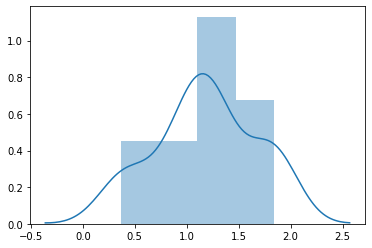

In [62]:
#investigate difference in stdev: centered around 1 so stdev of detrended doesn't drastically change
sb.distplot(sfrac)

## moving on from transition sources: focus on parameter space separation of types 5, 6, and 7

### adding calibrated statistics
- replacing past statistics in allsummtab
- adding calibration flag column
- deciding by-eye whether to use calibrated

In [63]:
alls['calibration flag'] = np.zeros(len(alls))

In [64]:
reload(o)

<module 'ogle' from '/Users/lenatreiber/Desktop/Yale/OGLE_Project/ogle.py'>

In [65]:
def calibrate(s,plotlc=False,window=200):
    try: iband,vband = o.getIV(s,cross,stack=False,both=True,plot=plotlc,mlist=mlist1,figsize=(4,3))
    except: iband,vband = o.getIV(s,cross2,stack=False,both=True,plot=plotlc,mlist=mlist2,figsize=(4,3))
    itemp = vstack(iband)
    med = np.median(itemp['I mag'])
    for i in iband:
        #calculate current median
        cmed = np.median(i['I mag'])
        #difference between current and target median
        dmeds = med-cmed
        #add difference to all points
        i['I mag'] += dmeds
    #new iband
    ib = vstack(iband)
    vb = vstack(vband) #not calibrating
    interp = o.colormag(ib,vb,retint=True,plot=False,printcorr=False)
    flatten,trend = o.splinedetrend(ib,window=window,retspline=True)
#     sp_std = np.nanstd(trend)
    det_std = np.nanstd(flatten)
    det_iqr = st.iqr(flatten,nan_policy='omit')
    o.addtotable(ib,vb,alls,s,interp,flag=True,det_std=det_std,det_iqr=det_iqr)

In [66]:
tocalib = [138,100,114,105,25,38,47,65,68,69,71,76,77,78,93,79,81,82,141,59,8,139] #list of sources to calibrate; adding to manually

In [67]:
type5 = gettype(num='5')

In [68]:
# plot(type7[17])

In [69]:
# for i in tocalib:
#     calibrate(i)

In [70]:
#write out allsummtab -- remember to also update allsumm (.numbers)
# alls.to_csv('allsummtab.csv',index=False)

#### compare stdevs using calibrated stats

Text(0.5, 0, 'Stdev I')

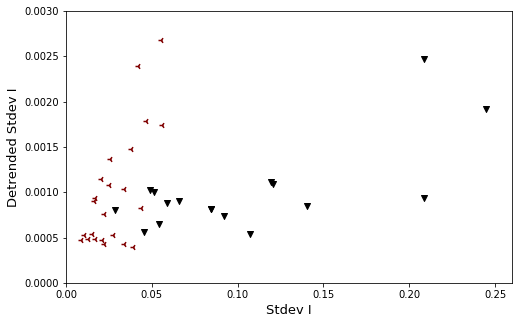

In [71]:
plt.figure(figsize=(8,5))
for t in type5:
    row = alls[alls['src_n']==t]
    plt.scatter(row['stdev I'],row['det stdev I'],marker='v',label='5',color='black')
#     plt.text(row['stdev I']+.005,row['det stdev I'],str(t))

for t in type6:
    row = alls[alls['src_n']==t]
    plt.scatter(row['stdev I'],row['det stdev I'],marker='3',label='6',color='maroon')
#     if t!= 77: plt.text(row['stdev I']+.005,row['det stdev I'],str(t))

plt.xlim(0,0.26)#outlier
plt.ylim(0,0.003)
plt.ylabel('Detrended Stdev I',fontsize=13)
plt.xlabel('Stdev I',fontsize=13)

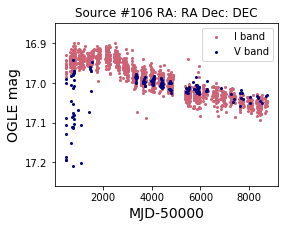

In [72]:
plot(106)

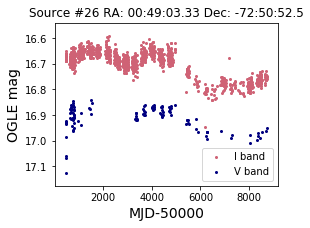

In [73]:
plot(26)

Text(0.5, 0, 'Stdev I')

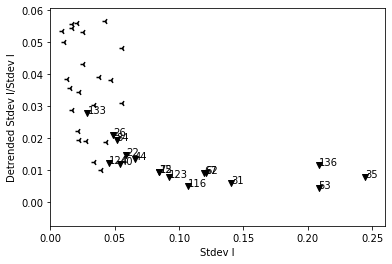

In [74]:
for t in type5:
    row = alls[alls['src_n']==t]
    plt.scatter(row['stdev I'],row['det stdev I']/row['stdev I'],marker='v',label='5',color='black')
    plt.text(row['stdev I'],row['det stdev I']/row['stdev I'],str(t))
for t in type6:
    row = alls[alls['src_n']==t]
    plt.scatter(row['stdev I'],row['det stdev I']/row['stdev I'],marker='3',label='6',color='black')
plt.xlim(0,0.26)#outlier
plt.ylabel('Detrended Stdev I/Stdev I')
plt.xlabel('Stdev I')

**if anything, another option is cutting in time to see variability on longer timescales**

#### compare all sources using calibrated stats

In [75]:
type1 = gettype(num='1')
type2 = gettype(num='2')
type3 = gettype(num='3')
type4 = gettype(num='4')

In [76]:
def tplot(typen,text=False,label='1',marker='o',color='black',x='stdev I',y='det stdev I'):
    for t in typen:
        row = alls[alls['src_n']==t]
        if t==typen[0]:plt.scatter(row[x],row[y],marker=marker,label=label,color=color)
        #otherwise no label
        plt.scatter(row[x],row[y],marker=marker,color=color)
        if text: plt.text(row[x],row[y],str(t))

(0, 0.4)

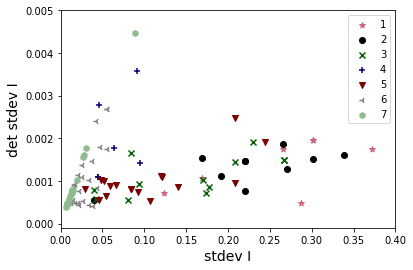

In [77]:
def fulltplot(x='stdev I',y='det stdev I',legend=True):
    tplot(type1,color=pink,marker='*',label='1',x=x,y=y)
    tplot(type2,color='black',label='2',x=x,y=y)
    tplot(type3,color='darkgreen',marker='x',label='3',x=x,y=y)
    tplot(type4,color='navy',marker='+',label='4',x=x,y=y)
    tplot(type5,marker='v',label='5',color='maroon',x=x,y=y)
    tplot(type6,marker='3',label='6',color='grey',x=x,y=y)
    tplot(type7,color='darkseagreen',marker='h',label='7',x=x,y=y)
    #plt.xlim(0,0.26)#outlier
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()
fulltplot()
plt.ylim(-.0001,.005)
plt.xlim(0,.4)

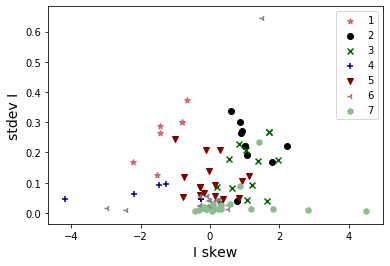

In [78]:
fulltplot(x='I skew',y='stdev I')

In [79]:
alls['det stdev/I stdev'] = alls['det stdev I']/alls['stdev I']

(0, 0.01)

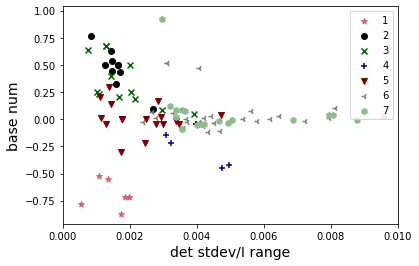

In [80]:
fulltplot(x='det stdev/I range',y='base num')
plt.xlim(0,.01)

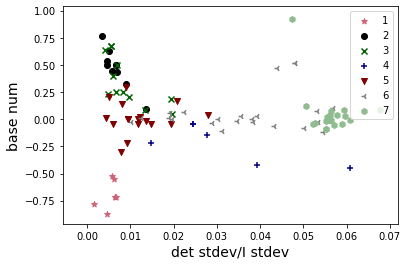

In [81]:
fulltplot(x='det stdev/I stdev',y='base num')
# plt.savefig('Figs/basenum_stdratio.png',dpi=200,bbox_inches='tight')

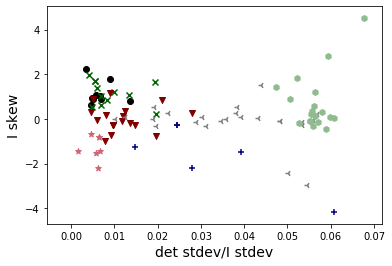

In [82]:
fulltplot(x='det stdev/I stdev',y='I skew',legend=False)
#similar

In [96]:
#don't have median so solve for it from base num
zrows = alls[alls['base num']==0]
zrows['base num'] = np.nan
alls[alls['base num']==0] = zrows


In [97]:
alls['base num'][:3]

0      NaN
1    0.673
2    0.087
Name: base num, dtype: float64

In [98]:
median = (alls['base num'] - alls['max I'] - alls['min I'])/2
alls['(max - median)/stdev'] = (alls['max I'] - median)/alls['stdev I']

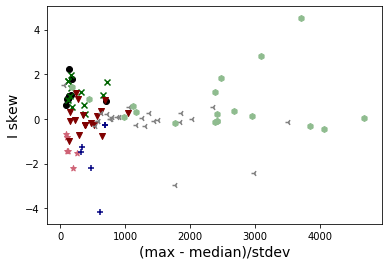

In [99]:
fulltplot(x='(max - median)/stdev',y='I skew',legend=False)
#also fairly nicely separated

(0, 0.006)

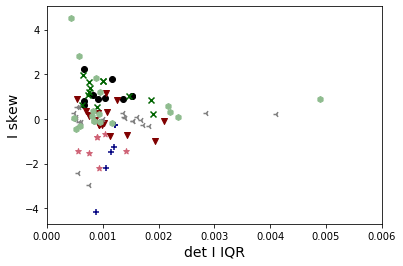

In [302]:
fulltplot(x='det I IQR',y='I skew',legend=False)
plt.xlim(0,.006)

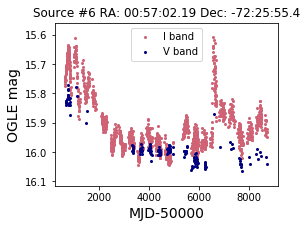

In [305]:
plot(type4[1])

### test case of smoothing with averaging rather than spline: type 4 sources

In [100]:
type4

[5, 6, 9, 60, 63]

In [289]:
ncut = 50
smooth = o.cut(5,cross,cross2,mlist1,mlist2,cut=ncut,npoints=False,time=False,retstd=False,retrange=False,calib=False,plot=False,text=False,statistic='mean',glob=True,retsplit=False,window=200)

(15.65, 15.375)

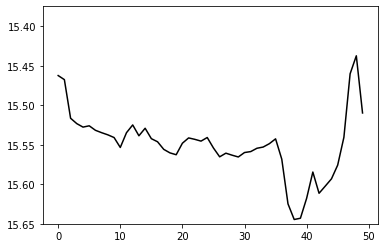

In [290]:
plt.plot(np.arange(ncut),smooth,color='black')
plt.ylim(15.65,15.375)

In [291]:
#note: this cell requires an ncut of 50 (not generalized)
detmag = []
for i in range(0,len(iband)-1,1+int(len(iband)/ncut)):
    ind = int(i/(1+int(len(iband)/ncut)))
    s = smooth[ind]
    detmag.append(list(iband['I mag'][i:i+1+int(len(iband)/ncut)]-s))
deti = [item for sublist in detmag for item in sublist]

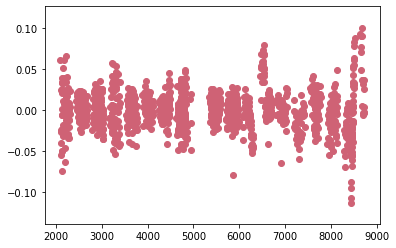

In [294]:
plt.scatter(iband['MJD-50000'],deti,color=pink)

In [295]:
np.std(deti) #"detrended"

0.021941195001551655

In [296]:
np.std(iband['I mag'])

0.04474693458278388

doesn't seem to work as well with sources with even sharper peaks, which makes sense

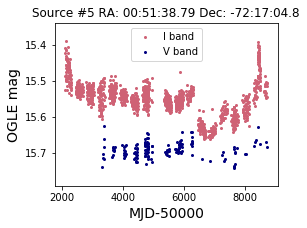

In [106]:
plot(5)

#### try out bootstrapping code
- can come back to this but no immediate use, because not separating the types


In [111]:
import sklearn.utils as sk

In [151]:
def boot(s,num=1000,npoints=500):
    bstd = []
    bskew = []
    bqr = []
    try:iband = o.getIV(s,cross,stack=True,both=False)
    except:iband = o.getIV(s,cross2,mlist=mlist2,stack=True,both=False)
    for i in range(num):
        bs = sk.resample(np.arange(len(iband)),n_samples=npoints)
        imag = np.array(iband['I mag'][bs])
        bstd.append(np.std(imag))
        bskew.append(st.skew(imag))
        bqr.append(st.iqr(imag,rng=[2,98]))
    return bstd,bskew,bqr

#### compare bootstrapped range of [2,98] for type 4 to types 6 and 5

In [171]:
t4rng = []
t6rng = []

for t in type4:
    std,skew,qr = boot(t)
    t4rng.append(np.max(qr)-np.min(qr))
for t in type6:
    std,skew,qr = boot(t)
    t6rng.append(np.max(qr)-np.min(qr))    

empty file for OIII I


In [170]:
#repeat for types 1 and 5
t1rng = []
t5rng = []

for t in type1:
    std,skew,qr = boot(t)
    t1rng.append(np.max(qr)-np.min(qr))
for t in type5:
    std,skew,qr = boot(t)
    t5rng.append(np.max(qr)-np.min(qr))    

In [176]:
#dist plot
t4rng

[0.051999999999997826,
 0.03312000000000381,
 0.21386000000000038,
 0.1767999999999983,
 0.13275999999999932]

In [152]:
std5,skew5,qr5 = boot(5)

0.04896000000000278


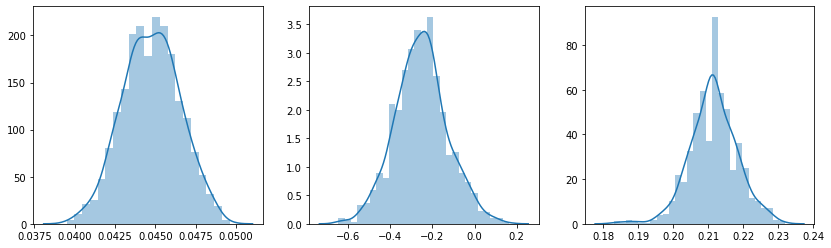

In [165]:
fig,ax = plt.subplots(1,3,figsize=(14,4))
sb.distplot(std5,ax=ax[0])
sb.distplot(skew5,ax=ax[1])
sb.distplot(qr5,ax=ax[2])
print(np.max(qr5)-np.min(qr5))

0.03904000000000174


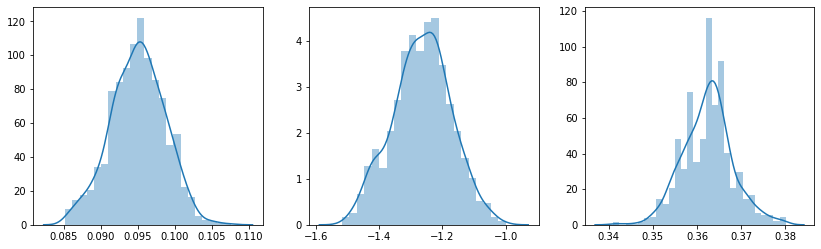

In [159]:
std,skew,qr = boot(type4[1])
fig,ax = plt.subplots(1,3,figsize=(14,4))
sb.distplot(std,ax=ax[0])
sb.distplot(skew,ax=ax[1])
sb.distplot(qr,ax=ax[2])
print(np.max(qr)-np.min(qr))

0.22613999999999912


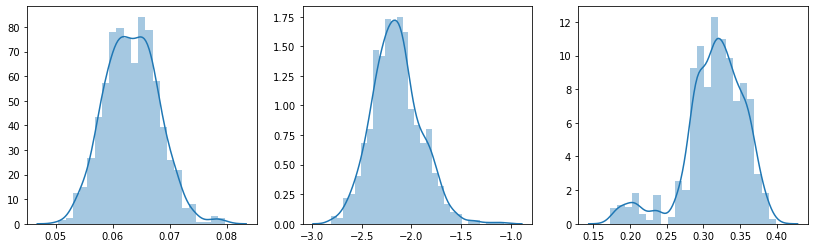

In [160]:
#only one peak and one dip --> high uncertainty on skew and [2,98]
std,skew,qr = boot(type4[2])
fig,ax = plt.subplots(1,3,figsize=(14,4))
sb.distplot(std,ax=ax[0])
sb.distplot(skew,ax=ax[1])
sb.distplot(qr,ax=ax[2])
print(np.max(qr)-np.min(qr))

0.20094000000000456


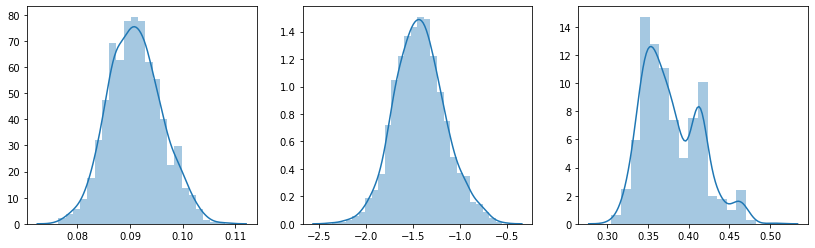

In [162]:
std,skew,qr = boot(type4[3])
fig,ax = plt.subplots(1,3,figsize=(14,4))
sb.distplot(std,ax=ax[0])
sb.distplot(skew,ax=ax[1])
sb.distplot(qr,ax=ax[2])
print(np.max(qr)-np.min(qr))

0.2082000000000015


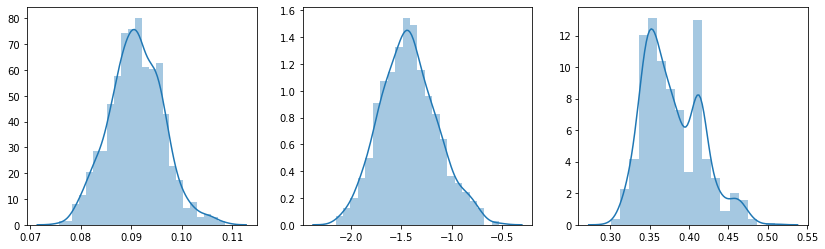

In [164]:
std,skew,qr = boot(type4[3])
fig,ax = plt.subplots(1,3,figsize=(14,4))
sb.distplot(std,ax=ax[0])
sb.distplot(skew,ax=ax[1])
sb.distplot(qr,ax=ax[2])
print(np.max(qr)-np.min(qr))

0.043960000000002

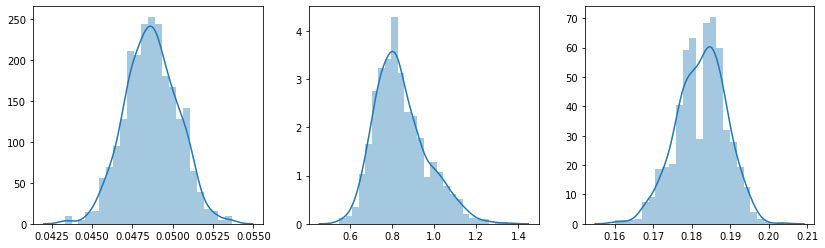

In [166]:
std26,skew26,qr26 = boot(26)
fig,ax = plt.subplots(1,3,figsize=(14,4))
sb.distplot(std26,ax=ax[0])
sb.distplot(skew26,ax=ax[1])
sb.distplot(qr26,ax=ax[2])
np.max(qr26)-np.min(qr26)

#### some quick color comparison
- start tying together color-mag and type

In [311]:
#re-calculate loop metric
nmfrac = alls['bright res monotonic frac']/np.nanmax(alls['bright res monotonic frac'])
nresdiff = (alls['mean abs bright residual']-alls['mean abs faint residual'])/np.nanmax(alls['mean abs bright residual']-alls['mean abs faint residual'])
nslope = alls['residual slope diff']/np.nanmax(alls['residual slope diff'])
bfdiff = (alls['bright slope']-alls['faint slope'])/np.nanmax(alls['bright slope']-alls['faint slope'])

In [314]:
alls['loop metric'] = nmfrac + nresdiff + nslope 
alls['loop metric 2'] = nmfrac + nresdiff + nslope + bfdiff #unsure about inclusion of bfdiff

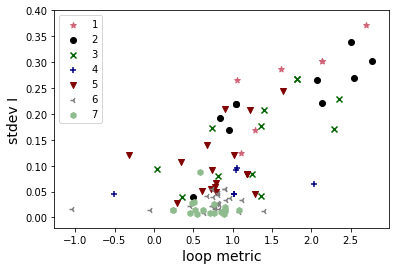

In [382]:
fulltplot(x='loop metric',y='stdev I',legend=True)
#cut off outlier at high stdev, low loop metric
plt.ylim(-.02,.4)
# plt.savefig('Figs/stdev_loop.png',dpi=150,bbox_inches='tight')

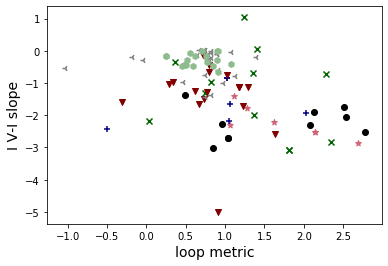

In [317]:
# 6 and 7 with lower abs value slopes
fulltplot(x='loop metric',y='I V-I slope',legend=False)


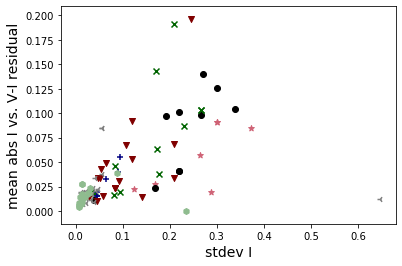

In [383]:
#even though they have loops, overall residuals for type 1 sources low given their stdevs
fulltplot(x='stdev I',y='mean abs I vs. V-I residual',legend=False)
plt.savefig('Figs/stdev_res.png',dpi=150,bbox_inches='tight')

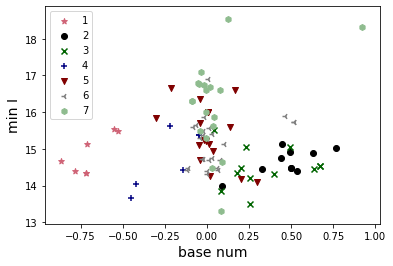

In [330]:
#do certain types not go to certain luminosities? e.g., 1,2
fulltplot(x='base num',y='min I',legend=True)

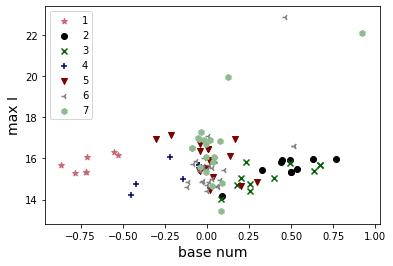

In [333]:
fulltplot(x='base num',y='max I',legend=True)

(0.4, 0.8)

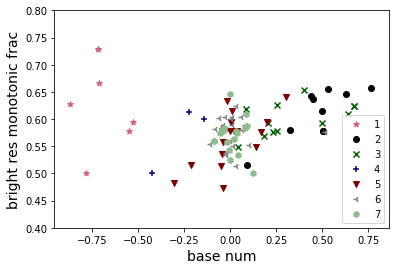

In [345]:
fulltplot(x='base num',y='bright res monotonic frac',legend=True)
#cut out low monotonic fracs
plt.ylim(.4,.8)

### quick PCA

In [338]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [346]:
def fullpca(tab,features,n=2,retdf=True,addpart=True):
    '''Standardize features and perform pca with n components'''
    #only keep rows where feature is not a nan
    df = tab[np.isnan(tab[features[0]])==False]
    #loop through remaining features
    for f in features[1:]:
        df = df[np.isnan(df[f])==False]
    print(len(df))
    x = df.loc[:, features]
    # Separating out the target
    y = df.loc[:,['src_n']]
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #perform PCA with n components
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(x)
    columns = ['']*n
    for c in range(1,n+1):
        columns[c-1] = f'pc {c}'
    pdf = pd.DataFrame(data = principalComponents, columns = columns)
    #add part to pdf
    if addpart:
        part = np.array(df['Part'])
        pdf['Part'] = part
        pdf['src_n'] = df['src_n']
    print(f'explained variance by component:{pca.explained_variance_ratio_}')
    if retdf: return df,pdf
    else: return pdf

In [395]:
features = ['base num','I skew', 'stdev I','I range','det stdev I','I kurtosis','spin period','mean I','I V-I slope','best auto det pd']
df,pdf = fullpca(alls,features,n=3)

90
explained variance by component:[0.30063501 0.17989949 0.14612141]


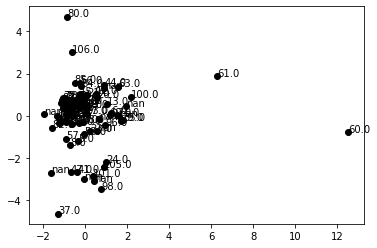

In [396]:
plt.scatter(pdf['pc 1'],pdf['pc 2'],color='black')
for p in range(len(pdf)):
    plt.annotate(str(pdf.loc[p]['src_n']),xy=(pdf.loc[p]['pc 1'],pdf.loc[p]['pc 2']))

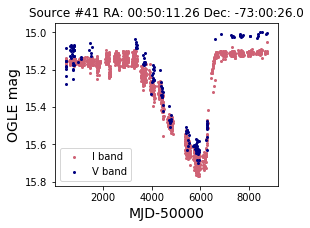

In [394]:
plot(41)